In [87]:
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np
from keras.optimizers import RMSprop
import ast

traindfstart= pd.read_csv("ODIR-5K_Training_Annotations_LR.csv")
testdfstart= pd.read_csv('XYZ_ODIR.csv')


datagen=ImageDataGenerator(rescale=1./255.,validation_split=(500/3500))

In [88]:
traindf = pd.DataFrame(np.repeat(traindfstart.values, 2, axis=0))
traindf.columns = traindfstart.columns

testdf = pd.DataFrame(np.repeat(testdfstart.values, 2, axis=0))
testdf.columns = testdfstart.columns

In [89]:
traindf

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,class-left,class-right,Diseases
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,['C'],['N'],['C']
1,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,['C'],['N'],['C']
2,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,['N'],['N'],['N']
3,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,['N'],['N'],['N']
4,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,['D'],['D'],"['D', 'O']"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4689,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,1,0,0,0,0,0,0,['D'],['N'],['D']
6996,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,['D'],['D'],['D']
6997,4690,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,['D'],['D'],['D']
6998,4784,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular degeneration,hypertensive retinopathy，age-related macular degeneration,0,0,0,0,1,1,0,0,"['D', 'A', 'H']","['D', 'A', 'H']","['A', 'H']"


In [90]:
def append_extension(fn, side):
    return f"{fn}_{side}.jpg"

# Create a new column 'Side' based on the index
traindf['Side'] = traindf.index % 2
testdf['Side'] = testdf.index % 2

# Apply the appropriate extension based on the 'Side' column
traindf['ID'] = traindf.apply(lambda row: append_extension(row['ID'], 'left' if row['Side'] == 0 else 'right'), axis=1)
traindf['labels'] = np.where('left' in traindf['ID'], traindf['class-left'], traindf['class-right'])
# traindf['labels'] = [traindf['class-left'] if 'left' in x else traindf['class-left'] for x in traindf['ID']]

# Drop the 'Side' column if you don't need it anymore
traindf.drop(columns=['Side'], inplace=True)
testdf.drop(columns=['Side'], inplace=True)

In [91]:
traindf.head(10)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,class-left,class-right,Diseases,labels
0,0_left.jpg,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,['C'],['N'],['C'],['N']
1,0_right.jpg,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,['C'],['N'],['C'],['N']
2,1_left.jpg,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,['N'],['N'],['N'],['N']
3,1_right.jpg,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,['N'],['N'],['N'],['N']
4,2_left.jpg,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,['D'],['D'],"['D', 'O']",['D']
5,2_right.jpg,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,['D'],['D'],"['D', 'O']",['D']
6,3_left.jpg,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,['N'],['O'],['O'],['O']
7,3_right.jpg,66,Male,3_left.jpg,3_right.jpg,normal fundus,branch retinal artery occlusion,0,0,0,0,0,0,0,1,['N'],['O'],['O'],['O']
8,4_left.jpg,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,['O'],['D'],"['D', 'O']",['D']
9,4_right.jpg,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,['O'],['D'],"['D', 'O']",['D']


In [38]:
traindf['labels'] = traindf['labels'].apply(lambda x: ast.literal_eval(x))

In [15]:
traindf.dtypes

ID                           object
Patient Age                  object
Patient Sex                  object
Left-Fundus                  object
Right-Fundus                 object
Left-Diagnostic Keywords     object
Right-Diagnostic Keywords    object
N                            object
D                            object
G                            object
C                            object
A                            object
H                            object
M                            object
O                            object
class-left                   object
class-right                  object
Diseases                     object
labels                       object
dtype: object

In [16]:
# # Replace the class columns with the corresponding column name instead of 1
# traindf['N'] = traindf['N'].replace(1, 'N')
# traindf['D'] = traindf['D'].replace(1, 'D')
# traindf['G'] = traindf['G'].replace(1, 'G')
# traindf['C'] = traindf['C'].replace(1, 'C')
# traindf['A'] = traindf['A'].replace(1, 'A')
# traindf['H'] = traindf['H'].replace(1, 'H')
# traindf['M'] = traindf['M'].replace(1, 'M')
# traindf['O'] = traindf['O'].replace(1, 'O')

In [17]:
traindf

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,class-left,class-right,Diseases,labels
0,0_left.jpg,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,C,0,0,0,0,['C'],['N'],['C'],['C']
1,0_right.jpg,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,C,0,0,0,0,['C'],['N'],['C'],['N']
2,1_left.jpg,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,N,0,0,0,0,0,0,0,['N'],['N'],['N'],['N']
3,1_right.jpg,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,N,0,0,0,0,0,0,0,['N'],['N'],['N'],['N']
4,2_left.jpg,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,D,0,0,0,0,0,O,['D'],['D'],"['D', 'O']",['D']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4689_right.jpg,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,D,0,0,0,0,0,0,['D'],['N'],['D'],['N']
6996,4690_left.jpg,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,D,0,0,0,0,0,0,['D'],['D'],['D'],['D']
6997,4690_right.jpg,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,D,0,0,0,0,0,0,['D'],['D'],['D'],['D']
6998,4784_left.jpg,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,A,H,0,0,"['D', 'A', 'H']","['D', 'A', 'H']","['A', 'H']","['D', 'A', 'H']"


In [163]:
# for index in traindf.index:
#     traindf.at[index, 'labels'] = list(filter(lambda x: x != 0, traindf.at[index, 'labels']))

In [18]:
traindf

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,class-left,class-right,Diseases,labels
0,0_left.jpg,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,C,0,0,0,0,['C'],['N'],['C'],['C']
1,0_right.jpg,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,C,0,0,0,0,['C'],['N'],['C'],['N']
2,1_left.jpg,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,N,0,0,0,0,0,0,0,['N'],['N'],['N'],['N']
3,1_right.jpg,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,N,0,0,0,0,0,0,0,['N'],['N'],['N'],['N']
4,2_left.jpg,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,D,0,0,0,0,0,O,['D'],['D'],"['D', 'O']",['D']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6995,4689_right.jpg,54,Male,4689_left.jpg,4689_right.jpg,mild nonproliferative retinopathy,normal fundus,0,D,0,0,0,0,0,0,['D'],['N'],['D'],['N']
6996,4690_left.jpg,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,D,0,0,0,0,0,0,['D'],['D'],['D'],['D']
6997,4690_right.jpg,57,Male,4690_left.jpg,4690_right.jpg,mild nonproliferative retinopathy,mild nonproliferative retinopathy,0,D,0,0,0,0,0,0,['D'],['D'],['D'],['D']
6998,4784_left.jpg,58,Male,4784_left.jpg,4784_right.jpg,hypertensive retinopathy，age-related macular d...,hypertensive retinopathy，age-related macular d...,0,0,0,0,A,H,0,0,"['D', 'A', 'H']","['D', 'A', 'H']","['A', 'H']","['D', 'A', 'H']"


In [46]:
traindf = traindf[['ID', 'labels']]

In [47]:
traindf

,ID,labels
0,0_left.jpg,[C]
1,0_right.jpg,[N]
2,1_left.jpg,[N]
3,1_right.jpg,[N]
4,2_left.jpg,[D]
...,...,...
6995,4689_right.jpg,[N]
6996,4690_left.jpg,[D]
6997,4690_right.jpg,[D]
6998,4784_left.jpg,"[D, A, H]"


In [48]:
from collections import Counter
labels_count = Counter(label for lbs in traindf['labels'] for label in lbs)

In [49]:
total_count = sum(labels_count.values())
class_weights = {cls: total_count / count for cls, count in labels_count.items()}

In [65]:
class_weights

{0: 23.40894568690096,
 1: 2.3605025773195876,
 2: 3.7555099948744233,
 3: 8.150166852057842,
 4: 37.96373056994819,
 5: 28.0727969348659,
 6: 22.475460122699385,
 7: 26.167857142857144}

In [50]:
img_gen = ImageDataGenerator(rescale=1/255, validation_split=(500/3500))


In [51]:
img_iter = img_gen.flow_from_dataframe(
    traindf,
    shuffle=True,
    directory="./ODIR-5K_Training_Dataset/",
    x_col='ID',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=20,
    subset='training'
)

img_iter_val = img_gen.flow_from_dataframe(
    traindf,
    shuffle=False,
    directory="./ODIR-5K_Training_Dataset/",
    x_col='ID',
    y_col='labels',
    class_mode='categorical',
    target_size=(128, 128),
    batch_size=200,
    subset='validation'
)

Found 6000 validated image filenames belonging to 8 classes.
Found 1000 validated image filenames belonging to 8 classes.


In [52]:
from keras.applications import ResNet50
from tensorflow.keras.models import Model

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=None,
    pooling='avg'
)
for layer in base_model.layers:
    layer.trainable = False

predictions = Dense(8, activation='sigmoid')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [53]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam'
)

In [54]:
from itertools import tee  # finally! I found something useful for it
from sklearn import metrics
from keras.callbacks import Callback  # Import Callback from keras.callbacks
from sklearn.metrics import f1_score, precision_score, recall_score


class Metrics(Callback):
    def __init__(self, validation_generator, validation_steps, threshold=0.5):
        self.validation_generator = validation_generator
        self.validation_steps = validation_steps or len(validation_generator)
        self.threshold = threshold

    def on_train_begin(self, logs={}):
        self.val_f1_scores = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        # duplicate generator to make sure y_true and y_pred are calculated from the same observations
        gen_1, gen_2 = tee(self.validation_generator)
        y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
        y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        self.val_f1_scores.append(f1)
        self.val_recalls.append(recall)
        self.val_precisions.append(precision)
        print(f" - val_f1_score: {f1:.5f} - val_precision: {precision:.5f} - val_recall: {recall:.5f}")
        return

In [55]:
# Heb deze per ongeluk 2x gerund waardoor de error is, maar het hoort er wel tussen te staan
class_label_to_index = {'C': 0, 'N': 1, 'D': 2, 'O': 3, 'H': 4, 'M': 5, 'G': 6, 'A': 7}
class_weights = {class_label_to_index[label]: weight for label, weight in class_weights.items()}

In [56]:
metrics = Metrics(img_iter_val, validation_steps=3)
history = model.fit_generator(
    img_iter,
    epochs=5,
    steps_per_epoch=50,
    class_weight=class_weights,
    callbacks=[metrics]
)

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3810425857.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/5
50/50 [==============================] - ETA: 0s - loss: 25.2293

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.24280 - val_precision: 0.15723 - val_recall: 0.53810
50/50 [==============================] - 101s 2s/step - loss: 25.2293
Epoch 2/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 [==============================] - ETA: 0s - loss: 20.5365

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.23774 - val_precision: 0.16010 - val_recall: 0.48038
50/50 [==============================] - 137s 3s/step - loss: 20.5365
Epoch 3/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 [==============================] - ETA: 0s - loss: 20.2691

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.24934 - val_precision: 0.16228 - val_recall: 0.54503
50/50 [==============================] - 108s 2s/step - loss: 20.2691
Epoch 4/5


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


50/50 [==============================] - ETA: 0s - loss: 20.6725

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.23976 - val_precision: 0.15578 - val_recall: 0.53302
50/50 [==============================] - 102s 2s/step - loss: 20.6725


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 5/5
50/50 [==============================] - ETA: 0s - loss: 19.6124

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:21: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(self.validation_steps)).astype('int')
/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/3669762628.py:22: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (self.model.predict_generator(gen_2, steps=self.validation_steps) > self.threshold).astype('int')


 - val_f1_score: 0.26532 - val_precision: 0.43311 - val_recall: 0.54969
50/50 [==============================] - 101s 2s/step - loss: 19.6124


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


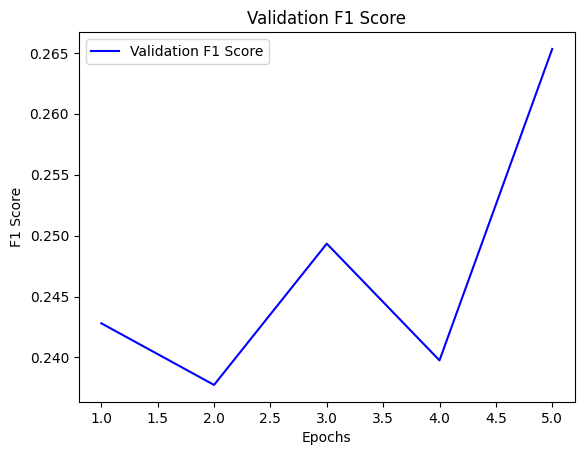

In [57]:
import matplotlib.pyplot as plt

# Access the metrics stored in the Metrics callback
val_f1_scores = metrics.val_f1_scores
val_precisions = metrics.val_precisions
val_recalls = metrics.val_recalls

# Plot the metrics
epochs = range(1, len(val_f1_scores) + 1)

plt.plot(epochs, val_f1_scores, 'b', label='Validation F1 Score')
plt.title('Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()


plt.show()


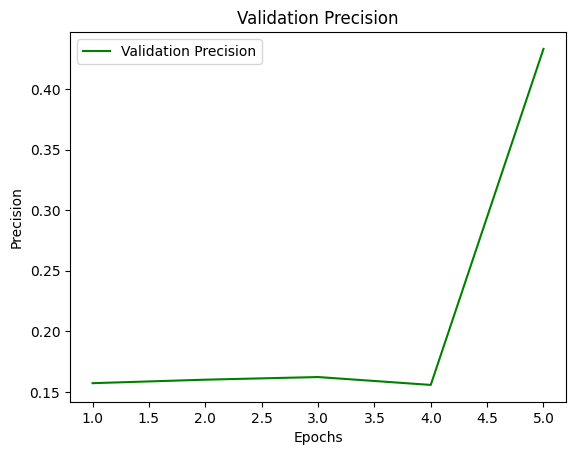

In [58]:
plt.plot(epochs, val_precisions, 'g', label='Validation Precision')
plt.title('Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.show()

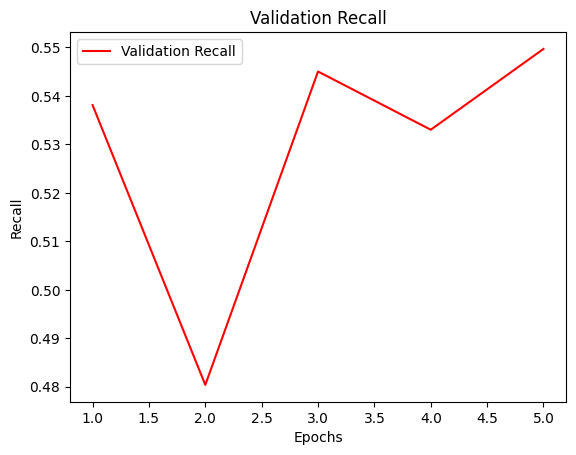

In [59]:
plt.plot(epochs, val_recalls, 'r', label='Validation Recall')
plt.title('Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

In [62]:
index_to_class = {0:'C', 1:'N', 2:'D', 3:'O', 4:'H', 5:'M', 6:'G', 7:'A'}


/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/2517598172.py:9: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(next(gen_1)[1] for _ in range(metrics.validation_steps)).astype('int')


/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_30681/2517598172.py:10: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = (model.predict_generator(gen_2, steps=metrics.validation_steps) > metrics.threshold).astype('int')


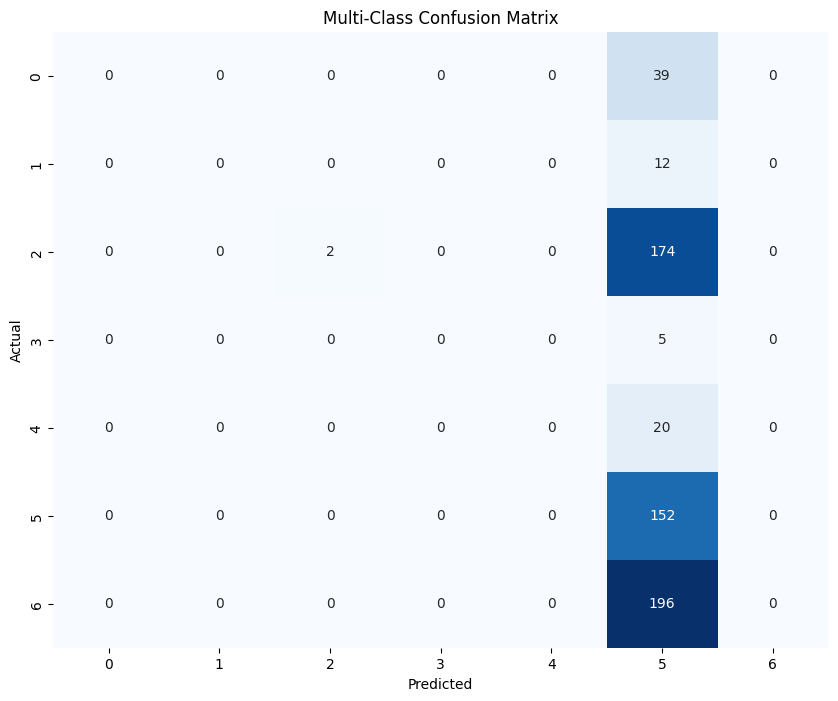

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# After training, calculate the confusion matrix on your validation data
gen_1, gen_2 = tee(metrics.validation_generator)
y_true = np.vstack(next(gen_1)[1] for _ in range(metrics.validation_steps)).astype('int')
y_pred = (model.predict_generator(gen_2, steps=metrics.validation_steps) > metrics.threshold).astype('int')

# Calculate the multi-class confusion matrix
confusion = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Multi-Class Confusion Matrix')
plt.show()

In [63]:

import xml.etree.ElementTree as ET
import itertools
import seaborn as sns
import sys
from sklearn.metrics import multilabel_confusion_matrix


def xml_to_labels(xml_data, unique_labels):
    root = ET.XML(xml_data)
    labels = set() if unique_labels else []
    labels_add = labels.add if unique_labels else labels.append
    for i, child in enumerate(root):
        if child.tag == 'filename':
            img_filename = child.text
        if child.tag == 'object':
            for subchild in child:
                if subchild.tag == 'name':
                    labels_add(subchild.text)
    return img_filename, list(labels)

def get_labels(annotations_dir, unique_labels=True):
    for annotation_file in annotations_dir.iterdir():
        with open(annotation_file) as f:
            yield xml_to_labels(f.read(), unique_labels)
            
def plot_confusion_matrix(cm, classes, title, ax):

    ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > cm.max() / 2. else "black")

    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks), ax.xaxis.set_ticklabels(classes)
    ax.set_yticks(tick_marks), ax.yaxis.set_ticklabels(classes)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Truth')
    ax.set_title(title)
    ax.grid(False)
    
def plot_multiclass_confusion_matrix(y_true, y_pred, label_to_class, save_plot=False):
    fig, axes = plt.subplots(int(np.ceil(len(label_to_class) / 2)), 2, figsize=(15, 60))
    axes = axes.flatten()
    for i, conf_matrix in enumerate(multilabel_confusion_matrix(y_true, y_pred)):
        tn, fp, fn, tp = conf_matrix.ravel()
        f1 = 2 * tp / (2 * tp + fp + fn + sys.float_info.epsilon)
        recall = tp / (tp + fn + sys.float_info.epsilon)
        precision = tp / (tp + fp + sys.float_info.epsilon)
        plot_confusion_matrix(
            np.array([[tp, fn], [fp, tn]]),
            classes=['+', '-'],
            title=f'Label: {label_to_class[i]}\nf1={f1:.5f}\nrecall={recall:.5f}\nprecision={precision:.5f}',
            ax=axes[i]
        )
        plt.tight_layout()
    if save_plot:
        plt.savefig('confusion_matrices.png', dpi=50)

In [64]:
pd.set_option('display.max_colwidth', 70)
plt.rcParams['figure.figsize'] = (25, 6)
sns.set(font_scale=2)
sns.set_style('ticks')


HIERONDER ZIJN PROBEERSELS VAN IETS ANDERS. HEBBEN DIT DEELS NODIG OM OOK RESULTATEN VAN DE TESTSET TE KRIJGEN
-
-
-
-
-
-
-
-
-
-


In [74]:
train_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        directory="./ODIR-5K_Training_Dataset/",
        x_col="ID",
        y_col= 'labels',
        subset="training",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="raw",
        target_size=(32,32))

valid_generator=datagen.flow_from_dataframe(
        dataframe=traindf,
        directory="./ODIR-5K_Training_Dataset/",
        x_col="ID",
        y_col= traindf.columns[7:],
        subset="validation",
        batch_size=32,
        seed=42,
        shuffle=True,
        class_mode="raw",
        target_size=(32,32))

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator=test_datagen.flow_from_dataframe(
        dataframe=testdf,
        directory="./ODIR-5K_Testing_Images/",
        x_col="ID",
        y_col=None,
        batch_size=32,
        seed=42,
        shuffle=False,
        class_mode=None,
        target_size=(32,32))

Found 6000 validated image filenames.
Found 1000 validated image filenames.
Found 1000 validated image filenames.


In [81]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(8, activation='sigmoid'))  # 8 is the number of label columns
model.add(Dropout(0.5))

# Compile the model with binary_crossentropy for multi-label classification
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10
)

/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_6202/3771039389.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator=train_generator,


Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/binary_crossentropy/mul/BroadcastGradientArgs' defined at (most recent call last):
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start
      self.io_loop.start()
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue
      await self.process_one()
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one
      await dispatch(*args)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell
      await result
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/florencecornelissen/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/0d/s7f5w3y14tjdxlssm2bbvqjc0000gn/T/ipykernel_6202/3771039389.py", line 4, in <module>
      model.fit_generator(generator=train_generator,
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 2810, in fit_generator
      return self.fit(
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 543, in minimize
      grads_and_vars = self.compute_gradients(loss, var_list, tape)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/optimizers/optimizer.py", line 276, in compute_gradients
      grads = tape.gradient(loss, var_list)
Node: 'gradient_tape/binary_crossentropy/mul/BroadcastGradientArgs'
Incompatible shapes: [32,128] vs. [32,8]
	 [[{{node gradient_tape/binary_crossentropy/mul/BroadcastGradientArgs}}]] [Op:__inference_train_function_7390]